In [1]:
import os
from cyclicityanalysis import OrientedArea, COOM
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from ou import OU


def save_figs(figs, file_path):
    with PdfPages(file_path) as pdf:
        for fig in figs:
            pdf.savefig(fig)
    pdf.close()


# Introduction

Fix $M,N \in \mathbb N.$ Let $\mathbf B$ be an $N \times N$ real matrix whose eigenvalues have positive real parts (i.e. $-\mathbf B$ is Hurwitz). Let $\boldsymbol \Sigma$ be an $N \times M$ real matrix such that $\left(\mathbf B, \boldsymbol \Sigma \right)$ is a rank-controllable pair. We consider an $N$-dimensional Ornstein-Uhlenbeck (OU) process $\{\mathbf x(t) \}_{t \geq 0}$ satisfying the following stochastic differential equation:
    \begin{align*}
        d\mathbf x(t) = -\mathbf B \ \mathbf x(t) \  dt + \boldsymbol \Sigma \ d\mathbf w(t),
    \end{align*}
in which:
- $\mathbf x(t) = (x_1(t), \ldots, x_N(t))$ is the state vector at time $t.$
- $\mathbf x(0)$ is a deterministic initial condition.
- $\left \lbrace \mathbf w(t) \right \rbrace_{t \ge 0}$ is an $M$-dimensional standard Wiener process.

The matrices $\mathbf B$ and $\boldsymbol \Sigma$ are respectively known as the **drift** and **volatility** matrices, which we consider here as the two model parameters. The $N \times N$ positive-semidefinite matrix $\mathbf D = \boldsymbol \Sigma \boldsymbol \Sigma^\top/2$ is known as the **diffusion matrix**. Under the above assumptions, the OU is a Gaussian and ergodic diffusion process whose stationary distribution is the Gaussian distribution with mean $\mathbf 0$ and covariance matrix $\mathbf S,$ in which $\mathbf S$ is the $N \times N$ positive-definite solution of the Lyapunov equation:
    \begin{align*}
        \mathbf B \mathbf S + \mathbf S \mathbf B^\top = 2 \mathbf D.
    \end{align*}
Explicitly,
    \begin{align*}
        \mathbf S = 2 \int_0^\infty \mathbf G(t) \ \mathbf D \ \left(\mathbf G(t) \right)^\top dt.
    \end{align*}
Any trajectory of the OU process initially drifts from its starting point $\mathbf x(0)$ and eventually fluctuates around the origin $\mathbf 0,$ with fluctuations varying according to the stationary distribution.

We simulate a trajectory of the OU process as follows. Let $K \in \mathbb N$ be a fixed number of iterations and $\Delta>0$ be a fixed time step. Let $\mathbf x_0 \in \mathbb R^N$ be the starting point of the trajectory and $\left \lbrace \boldsymbol \xi_k \right \rbrace_{k=1}^K$ be a sequence of $M$-dimensional vectors randomly chosen according to the standard $M$-dimensional Gaussian distribution. We define the discrete-time sequence $\left \lbrace \mathbf x_k \right \rbrace_{k=0}^{K-1}$ as follows:
    \begin{align*}
        \mathbf x_{k} = \mathbf x_{k-1} -  \Delta \ \mathbf B \ \mathbf x_{k-1} + \sqrt{\Delta} \ \boldsymbol \Sigma \ \boldsymbol \xi_{k}
    \end{align*}
for each $1 \le k <K.$ We consider this sequence as an approximation of a trajectory of the OU process over the time interval $[0, (K-1) \Delta].$

<Axes: title={'center': '10 Sample Trajectories of OU Process'}, xlabel='Time ($t$)'>

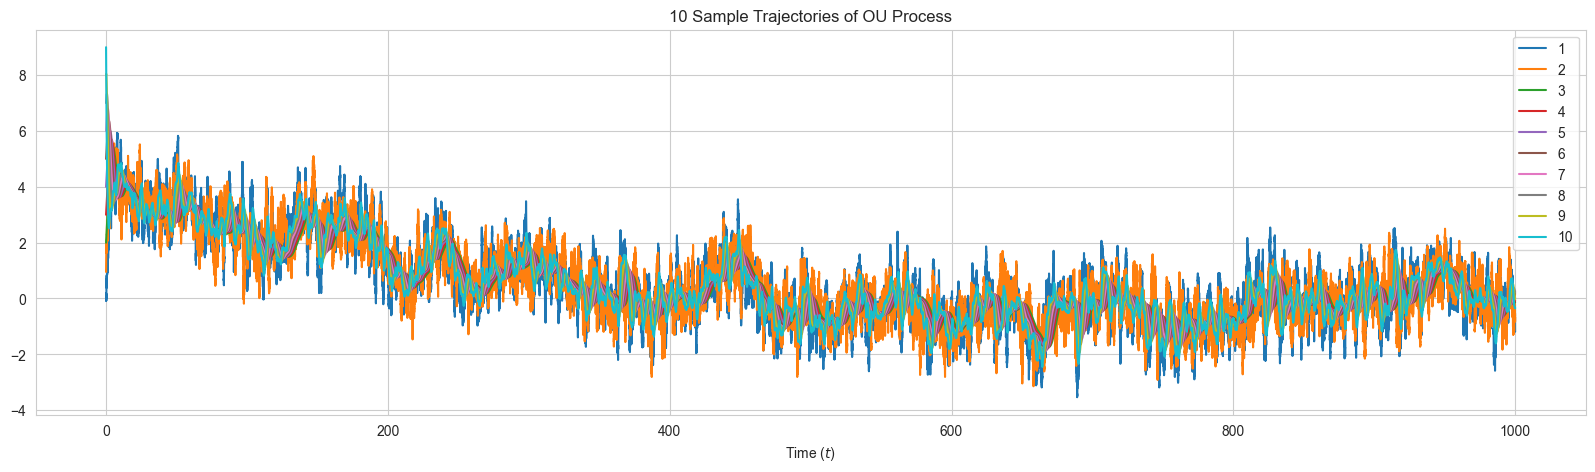

In [2]:
N = 10
M=2
B = np.zeros((N,N))
Sigma = np.zeros((N,M))
Sigma[0,0] = 1
Sigma[1,1] = 1
for n in range(N):
    B[n, (n+1)%N] = -1
    B[n,n] = 0.01 - np.sum(B[n])
ou = OU(B,Sigma)
trajectory_df = ou.simulate_trajectory_df(x0=np.arange(N))

fig,ax = plt.subplots(figsize=(20,5))
ax.set_title(f"{N} Sample Trajectories of OU Process")
trajectory_df.plot(ax=ax)

## Cyclicity Analysis

Let $T=[a,b]$ be a closed interval in the extended real line, which we regard as a continuous interval of time. Let $\mathbf y : T \rightarrow \mathbb R^N$ be a piecewise differentiable function, which we interpret as an $N$-dimensional signal. We write $\mathbf y = \left(y_1 \ , \ \dots \ , \ y_N \right),$ in which $y_n: T \rightarrow \mathbb R$ is the $n$-th component of $\mathbf y.$ **Cyclicity Analysis** is a study of the lead-lag dynamics amongst the components of $\mathbf y.$ It answers two main questions:
1. If two components of $\mathbf y$ evolve similarly throughout time, then which component leads the other?
2. If all components of $\mathbf y$ evolve similarly throughout time, then what is the temporal order in which the components evolve throughout time ?

For example, let $f: [-\infty,\infty] \rightarrow \mathbb R$ be the Gaussian signal defined by $f(t)=\exp(-t^2)$ with $f(\pm \infty)=0.$ Let $\mathbf y:[-\infty,\infty] \rightarrow \mathbb R^N$ satisfy $y_n(t)=f(t-(n-1))$ for each $1 \le n \le N.$ Then, the components of $\mathbf y$ evolve similarly throughout time up to time shifts. In particular $y_{n+1}$ is a time shifted copy of $y_n$ by one time unit for each $1 \le n < N,$ and so we interpret $y_n$ to lead $y_{n+1},$ or equivalently, $y_{n+1}$ to lag $y_n.$ Consequently, the identity permutation of the indices $\left \lbrace 1 \ , \ \dots \ , \  N \right \rbrace$ represents the temporal order in which the components of $\mathbf y$ evolve throughout time.


The main tool used to answer question one is the lead matrix. The **lead (-lag) matrix** of the signal $\mathbf y$ is the $N \times N$ real matrix $\mathbf A$ whose $(m,n)$-th entry is defined by:
    \begin{align*}
        A_{m,n} = \frac{1}{2} \int_a^b y_m(t) \ y_n'(t) - y_n(t) \ y_m'(t) \ dt.
    \end{align*}
Geometrically, $A_{m,n}$ is the oriented signed area enclosed by the concatenation of the curve $(y_m,y_n): T \rightarrow \mathbb R^2$ and the chord connecting its endpoints. The sign of $A_{m,n}$ indicates the lead-lag relationship between $y_m$ and $y_n.$ We interpret $y_m$ to lead (resp. lag) $y_n$ if $A_{m,n}>0$ (resp. $A_{m,n}<0$). If $A_{m,n}=0,$ then we interpret $y_m$ and $y_n$ to be synchronous. The lead matrix $\mathbf A$ is skew-symmetric i.e. $\mathbf A^\top = -\mathbf A.$ It is well-known $\mathbf A$ has even rank and its nonzero eigenvalues come in purely imaginary pairs. In particular, if $\lambda \in \mathbb C$ is a nonzero eigenvalue of $\mathbf A$ with associated eigenvector $\mathbf v = \left(v_1 \ , \ \dots \ , \ v_N \right) \in \mathbb C^N,$ then $-\lambda$ is also an eigenvalue of $\mathbf A$ with associated eigenvector $\overline{\mathbf v} = \left(\overline{v_1} \ , \ \dots \ , \ \overline{v_N} \right) \in \mathbb C^N,$ in which $\overline{z}$ denotes the complex conjugate of $z \in \mathbb C.$ The $n$-th **leading eigenvector** of $\mathbf A$ is the eigenvector associated with the $n$-th largest eigenvalue of $\mathbf A$ in modulus. The $n$-th leading eigenvector of $\mathbf A$ is unique up to complex conjugation of its components.

Now, we partially answer question two in a specific setting. Recall a signal $\phi: \mathbb R \rightarrow \mathbb R$ is periodic if there exists a minimal constant $P>0,$ known as the period of $\phi,$ such that $\phi(t)=\phi(t+P)$ for all $t \in \mathbb R.$ We emphasize $\phi$ is $P$-periodic.  It is well-known if $\phi$ is piecewise smooth, then $\phi$ can be written as the Fourier Series
    \begin{align*}
        \phi(t) = \sum_{k \in \mathbb Z} \hat{\phi}_k \ \exp \left(\frac{2 \pi i k}{P} \ t \right),
    \end{align*}
 where $\hat {\phi}_k$ is the $k$-th Fourier coefficient of $\phi.$

Assume $\mathbf y: \mathbb R \rightarrow \mathbb R^N$ is a piecewise smooth signal satisfying a Chain of Offsets Model (COOM), which stipulates the existence of an underlying one-dimensional $P$-periodic signal $\phi: \mathbb R \rightarrow \mathbb R$ with scaling constants $c_1 \ , \ \dots \ , \ c_N>0$ and distinct offsets (time shifts) $0 \le \alpha_1 \ , \ \dots \ , \ \alpha_N <P$ such that
    \begin{align*}
        y_n(t) = c_n \ \phi(t-\alpha_n)
    \end{align*}
for each $1 \le n \le N.$ In other words, each $y_n$ is a scaled and time-shifted version of some underlying periodic signal. In COOM, we interpret $y_m$ to lead (resp. lag) $y_n$ if $\alpha_m < \alpha_n$ (resp. $\alpha_m > \alpha_n$). Determining the temporal order of the component signals under COOM amounts to determining the permutation $\sigma$ of the indices $\left \lbrace 1 \ , \ \dots \ , \  N \right \rbrace$ such that $\alpha_{\sigma(1)} < \alpha_{\sigma(2)} < \dots < \alpha_{\sigma(N)}.$ However, $\sigma$ is not unique in the traditional sense, but it is unique up to a cyclic shift of indices. So we emphasize $\sigma$ represents the **cyclic order** of the offsets in COOM. Geometrically, the cyclic order of the offsets is cyclic order in which the points $\exp\left( \frac{2 \pi i \alpha_1}{P} \right) \ , \ \dots \ , \ \exp\left( \frac{2 \pi i \alpha_N}{P} \right)$ appear on the unit circle in the counter-clockwise direction. In certain baseline situations, the leading eigenvector of the lead matrix $\mathbf A$ of $\mathbf y$ over the interval $[0,T]$ enables us to recover the cyclic order of the offsets in COOM. For example, suppose $\phi$ has exactly one harmonic i.e. $\hat{\phi}_{\pm k} \ne 0$ for exactly one index $k \in \mathbb N.$ Then, the lead matrix $\mathbf A$ is rank $2.$ If $\mathbf v = \left(v_1 \ , \ \dots \ , \ v_N \right)$ is the first leading eigenvector of $\mathbf A,$ then its components lie on an ellipse. The cyclic order in which these components lie on the ellipse coincides with the cyclic order of the offsets in COOM. Thus, we can recover the cyclic order of the offsets in COOM by sorting the arguments of the components of $\mathbf v.$


(<Figure size 2500x500 with 6 Axes>,
 array([<Axes: title={'center': 'Lead Matrix'}>,
        <Axes: title={'center': 'Sorted Eigenvalue Moduli'}, xlabel='Index', ylabel='Modulus'>,
        <Axes: title={'center': 'Leading Eigenvector 1'}, xlabel='Real', ylabel='Imaginary'>,
        <Axes: title={'center': 'Leading Eigenvector 1 Component Moduli'}, xlabel='Index', ylabel='Modulus'>,
        <Axes: title={'center': 'Leading Eigenvector 1 Component Phases'}, xlabel='Index', ylabel='Phase'>],
       dtype=object))

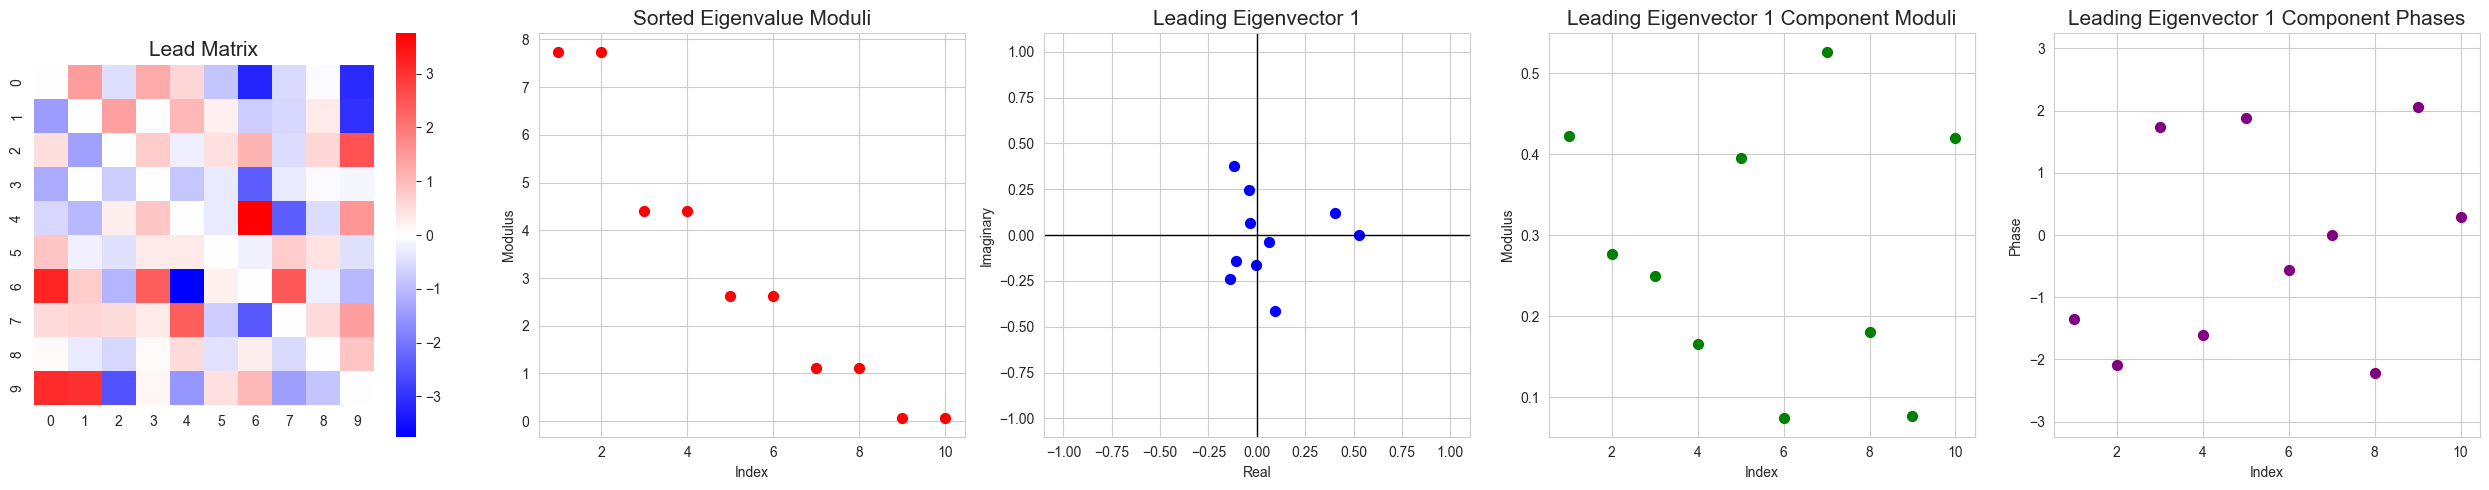

In [3]:
def plot_cyclicity(coom, index =1, figsize=(25,5), title_size=15, marker_size=50, label_size=10):
    A = coom.skew_symmetric_df.values
    N = coom.N
    v, phases, sequential_order = coom.compute_sequential_order(index-1)
    v/=np.linalg.norm(v)
    fig,axs = plt.subplots(1,5, figsize=figsize)

    axs[0].set_title("Lead Matrix", fontsize=title_size)
    sns.heatmap(coom.skew_symmetric_df,cmap='bwr', ax = axs[0], square=True)

    axs[1].set_title("Sorted Eigenvalue Moduli", fontsize=title_size)
    axs[1].scatter(np.arange(1,N+1), np.sort(np.abs(np.linalg.eigvals(A)))[::-1], s= marker_size, color='r')
    axs[1].set_xlabel("Index", fontsize=label_size)
    axs[1].set_ylabel("Modulus", fontsize=label_size)

    axs[2].set_title(f"Leading Eigenvector {index}", fontsize=title_size)
    axs[2].scatter(v.real, v.imag, s=marker_size, color='blue')
    axs[2].axhline(0, color='black', lw=1)
    axs[2].axvline(0, color='black', lw=1)
    axs[2].set_xlim(-1.1,1.1)
    axs[2].set_ylim(-1.1,1.1)
    axs[2].set_xlabel("Real", fontsize=label_size)
    axs[2].set_ylabel("Imaginary", fontsize=label_size)

    axs[3].set_title(f"Leading Eigenvector {index} Component Moduli", fontsize=title_size)
    axs[3].scatter(np.arange(1,N+1), np.abs(v), s=marker_size, color='green')
    axs[3].set_xlabel("Index", fontsize=label_size)
    axs[3].set_ylabel("Modulus", fontsize=label_size)

    axs[4].set_title(f"Leading Eigenvector {index} Component Phases", fontsize=title_size)
    axs[4].scatter(np.arange(1,N+1), phases, s=marker_size, color='purple')
    axs[4].set_ylim(-np.pi-0.1,np.pi+0.1)
    axs[4].set_xlabel("Index", fontsize=label_size)
    axs[4].set_ylabel("Phase", fontsize=label_size)

    fig.tight_layout()
    return fig, axs


N=10
A = np.random.randn(N,N)
A -= A.T
coom = COOM(A)
plot_cyclicity(coom)

## Problem Statement

Consider the OU process with model parameters $\mathbf B$ and $\boldsymbol \Sigma$ as defined above. For the purposes of Cyclicity Analysis, we consider the auxiliary $N \times N$ **lead process** $\left \lbrace \mathbf A(t) \right \rbrace_{t \ge 0},$ in which
    \begin{align*}
        \mathbf A(t) = \frac{1}{2} \int_0^t \mathbf x(s) \ \left(d\mathbf x(s)\right)^\top - d\mathbf x(s) \ \left(\mathbf x(s)\right)^\top
    \end{align*}
 is the $N \times N$ random matrix representing the lead matrix of a trajectory of the OU process over the time interval $[0,t].$

**Theorem**: We have the following strong law of large numbers identity:
    \begin{align*}
        \lim_{t \rightarrow \infty} \frac{\mathbf A(t)}{t} = \frac{\mathbf B \mathbf S - \mathbf S \mathbf B^\top}{2} \text{ a.s.}
    \end{align*}
 This means we can infer the long term pairwise lead-lag dynamics amongst the components of the OU process via a single trajectory. For this reason, we define $\mathbf Q = \frac{\mathbf B \mathbf S - \mathbf S \mathbf B^\top}{2}$ as the **lead matrix** of the OU process.


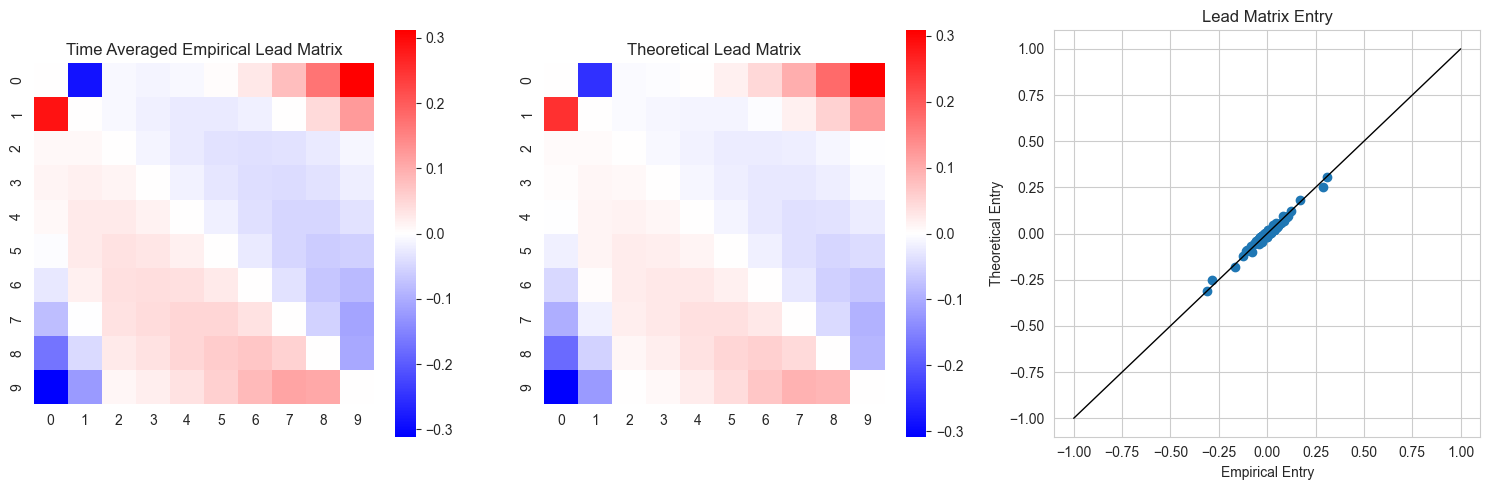

In [4]:
T=trajectory_df.index[-1]
empirical_lead_matrix  = OrientedArea(trajectory_df).compute_lead_lag_df().values
theoretical_lead_matrix = ou.Q
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].set_title("Time Averaged Empirical Lead Matrix")
sns.heatmap(empirical_lead_matrix/T, square=True, cmap='bwr', ax=axs[0])
axs[1].set_title("Theoretical Lead Matrix")
sns.heatmap(theoretical_lead_matrix, square=True, cmap='bwr', ax=axs[1])
axs[2].set_title("Lead Matrix Entry")
axs[2].scatter(empirical_lead_matrix.flatten()/T, theoretical_lead_matrix.flatten())
axs[2].set_xlabel("Empirical Entry")
axs[2].set_ylabel("Theoretical Entry")
axs[2].plot([-1,1],[-1,1], color='black', lw=1)
fig.tight_layout()

We now consider a signal propagation model governed by the OU process. In this model, a one-dimensional signal propagates throughout a network consisting of $N$ sensors. We interpret $x_n(t)$ as the measurment of the signal by the $n$-th sensor at time $t.$ The drift matrix $\mathbf B$ encodes the sensor network structure, while the volatility matrix $\boldsymbol \Sigma,$ through the diffusion matrix $\mathbf D,$ encodes the noise structure. Given the model parameters $\mathbf B$ and $\boldsymbol \Sigma,$ we investigate whether Cyclicity Analysis enables us to recover the structure of the sensor network for large dimension $N$. In particular, we investigate whether the structure of the first leading eigenvector of the lead matrix $\mathbf Q$ reflects the networks structure.

# Cyclic OU Process

Recall an $N \times N$ real matrix $\mathbf A$ with first row $\mathbf a = \left(a_1 \ , \ \dots \ ,\ a_N \right) \in \mathbb R^N$ is **circulant** if the $n$-th row of $\mathbf A$ is of the form $\left(a_{1+n-1} \ , \ \dots \ ,\  a_{N+n-1} \right)$ for each $1 \le n \le N,$ in which the indices are taken modulo $N.$ In other words, the $n$-th row of $\mathbf A$ is $n-1$ right cyclic shifts of its first row. We denote $\text{Circ}(\mathbf a)$ as the $N \times N$ circulant matrix whose first row is $\mathbf a \in \mathbb R^N.$

**Theorem**: For each $1 \le n \le N,$ we have
    \begin{align*}
        \mu_n &= \sum_{p=1}^N a_p \ \omega_n^{p-1}
    \end{align*}
is an eigenvalue of $\text{Circ}(\mathbf a)$ with associated eigenvector
    \begin{align*}
        \boldsymbol \omega_n &= \frac{1}{\sqrt{N}} \left(1 \ , \  \omega_n \ , \ \dots \ , \ \omega_n^{N-1} \right),
    \end{align*}
where $\omega_n = \exp \left(\frac{2 \pi i n}{N} \right)$ is the $n$-th root of unity.

Moreover, $\left \lbrace \boldsymbol \omega_n \right \rbrace_{n=1}^N$ is an orthonormal basis of $\mathbb C^N$ i.e. $\boldsymbol \omega_m^\ast \boldsymbol \omega_n = \delta_{m,n}$ for each $1 \le n,m \le N,$ in which $\boldsymbol \omega_m^\ast= \boldsymbol \omega_{N-m}^\top$ is the conjeugate transpose of $\boldsymbol \omega_n$ and $\delta_{n,m}$ is the Kronecker delta. Finally, we have
    \begin{align*}
        \text{Circ}(\mathbf a) &= \sum_{n=1}^N \mu_n \ \boldsymbol \omega_n \ \boldsymbol \omega_{N-n}^\top \\
        \exp \left(t \ \text{Circ}(\mathbf a) \right) &= \sum_{n=1}^N \exp(t \mu_n) \ \boldsymbol \omega_n \ \boldsymbol \omega_{N-n}^\top.
    \end{align*}
 for each $t \ge 0.$

<Axes: title={'center': '10x10 Circulant Matrix'}>

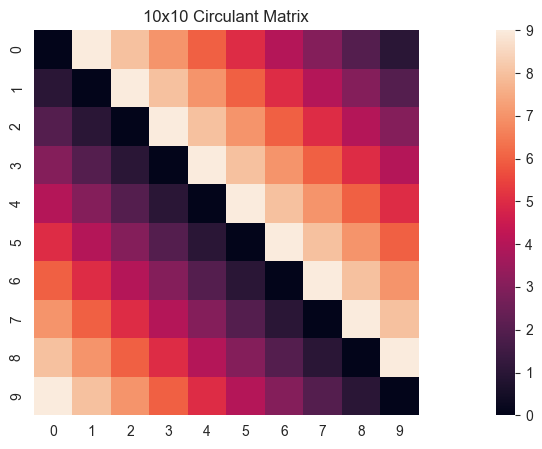

In [5]:
N = 10
a = np.arange(N)
A = sc.linalg.circulant(a)
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title(f"{N}x{N} Circulant Matrix")
sns.heatmap(A,square=True)

The **Cyclic OU process** is the OU process whose drift matrix is of the form $\text{Circ}(\mathbf b)$ with $b_2 \ , \ \dots \ ,\ b_N \le 0$ and $b_1 > -\sum_{p=2}^N b_p.$ In our signal propagation model, for each $1<p \le N,$ the magnitude of $b_p$ represents the strength of the signal propagation from the $n$-th sensor to the $(n+p-1)$-th sensor for each $1 \le n \le N,$ in which the indices are taken modulo $N.$ Meanwhile, the magnitude of $b_1$ represents the rate at which the signal dissipates as it propagates throughout the network. We write $b_1 = \epsilon - \sum_{p=2}^N b_p,$ where $\epsilon>0$ is a perturbation. From now on, we consider $b_2 \ , \ \dots \ ,\ b_N, \epsilon,$ and the volatility matrix $\boldsymbol \Sigma$ as the model parameters of the Cyclic OU process. We parameterize the lead matrix, along with its leading eigenvectors, by $\epsilon.$

**Theorem**: For all $\epsilon>0,$ the lead matrix of the Cyclic OU process is given by
    \begin{align*}
        \mathbf Q(\epsilon) = \sum_{m,n=1}^N \frac{\sum_{p=2}^N b_p \left(\omega_m^{p-1} - \omega_n^{p-1} \right)}{2 \epsilon+ \sum_{q=2}^N b_q \left(\omega_m^{q-1} + \omega_n^{q-1} -2 \right)} \ \boldsymbol \omega_m \ \boldsymbol \omega_{N-m}^\top \  \mathbf D \  \boldsymbol \omega_{N-n} \ \boldsymbol \omega_{n}^\top.
    \end{align*}

## Single Source, Single Direction (SSSD)

Consider the cyclic OU model in which $b_p$ is nonzero for exactly one index $1<p \le N.$ In this case, the $n$-th sensor is only receptive to the $(n+p-1)$-th sensor to its right.  Suppose $\boldsymbol \Sigma$ is a volatility matrix such that the diffusion matrix $\mathbf D$ is a diagonal matrix with $d_s=D_{s,s}$ is nonzero for exactly one index $1 \le s \le N.$ In this case, noise is only injected into the $s$-th sensor with variance $d_s.$ We refer to this model as the **Single Source, Single Direction (SSSD)**.

**Theorem**: For all $\epsilon>0,$ the lead matrix of the Cyclic OU process is given by
    \begin{align*}
        \mathbf Q(\epsilon) = \frac{d_s}{N} \sum_{m,n=1}^N \frac{\left(\omega_m^{p-1} - \omega_n^{p-1} \right) \  \omega_{m+n}^{1-s} }{\frac{2 \epsilon}{b_p} + \omega_m^{p-1} + \omega_n^{p-1} -2 } \ \boldsymbol \omega_m \  \boldsymbol \omega_{n}^\top.
    \end{align*}

Observe $d_s$ is a multiplicative factor of $\mathbf Q(\epsilon).$ Thus, $d_s$ does not affect the structure of the leading eigenvectors of $\mathbf Q(\epsilon).$ For this reason, we may assume without loss of generality that $d_s=1.$

In [6]:
def plot_sssd_cyclicity(N, p,s, epsilon, propagation_coeff=-1, leading_eigenvector_index=1, figsize=(25,5), title_size=15, marker_size=50, label_size=10):
    b = np.zeros(N)
    b[p-1] = propagation_coeff
    b[0] = epsilon - np.sum(b)
    Sigma = np.zeros((N,N))
    Sigma[s-1,s-1] = 1
    try:
        ou = OU(sc.linalg.circulant(b), Sigma)
        coom = COOM(ou.Q)
        fig, axs = plot_cyclicity(coom, index=leading_eigenvector_index, figsize=figsize, title_size=title_size, marker_size=marker_size, label_size=label_size)
        for ax in axs:
            title = ax.get_title() + "\n"
            title += f"$p={p}, b_{p}={np.round(propagation_coeff,3)}, s={s}, ε={np.round(epsilon,3)}$"
            ax.set_title(title, fontsize=title_size)
        fig.tight_layout()
    except:
        fig, axs = plt.subplots(1,1)
        axs.set_title("Invalid Parameters")
        fig.tight_layout()


In [20]:
import ipywidgets as widgets
from ipywidgets import interact

@interact(
    N=widgets.IntSlider(value=10, min=2, max=100, step=1, description='$N$'),
    p=widgets.IntSlider(value=2, min=2, max=100, step=1, description='$p$'),
    s=widgets.IntSlider(value=1, min=1, max=100, step=1, description='$s$'),
    epsilon=widgets.FloatSlider(value=0.01, min=0.01, max=100, step=0.01, description='$\\epsilon$'),
    leading_eigenvector_index = widgets.IntSlider(value=1, min=1, max=10, step=1, description='leading_eigenvector_index'),
    propagation_coeff=widgets.FloatSlider(value=-1, min=-1000, max=-0.01, step=0.01, description='$b_p$')
)
def interactive_plot_sssd_cyclicity(N, p, s, epsilon, propagation_coeff,leading_eigenvector_index):
    plot_sssd_cyclicity(N, p, s, epsilon, propagation_coeff,leading_eigenvector_index)

interactive(children=(IntSlider(value=10, description='$N$', min=2), IntSlider(value=2, description='$p$', min…

In [42]:
ou.Q

array([[ 0.        , -0.24995098, -0.00490097, -0.00456584,  0.00155193,
         0.01707064,  0.04681711,  0.09766389,  0.17990268,  0.30833793],
       [ 0.24995098,  0.        , -0.00533412, -0.01077492, -0.01393575,
        -0.01233442, -0.00309333,  0.01737838,  0.05506549,  0.12284262],
       [ 0.00490097,  0.00533412,  0.        , -0.0078296 , -0.01581579,
        -0.02182219, -0.02362691, -0.01996116, -0.01161034, -0.00180889],
       [ 0.00456584,  0.01077492,  0.0078296 ,  0.        , -0.0101257 ,
        -0.02045392, -0.0277652 , -0.02871122, -0.02164399, -0.00855493],
       [-0.00155193,  0.01393575,  0.01581579,  0.0101257 ,  0.        ,
        -0.01355172, -0.02737448, -0.03635267, -0.03516593, -0.0218468 ],
       [-0.01707064,  0.01233442,  0.02182219,  0.02045392,  0.01355172,
         0.        , -0.01894379, -0.03826646, -0.04918838, -0.0425786 ],
       [-0.04681711,  0.00309333,  0.02362691,  0.0277652 ,  0.02737448,
         0.01894379,  0.        , -0.02810986